In [360]:
import numpy as np

In [361]:
import matplotlib.pyplot as plt

# Функции

## Функции операторов  
- принимают параметры сетки и размерность задачи
- возвращают двумерный numpy массив

In [362]:
def second_derivative_operator(size, L):
  dx=L/size
  matrix = np.eye(size)
  i,j=np.indices(matrix.shape)
  matrix[i==j]=-2
  matrix[i==j-1]=1
  matrix[i==j+1]=1
  matrix[0][size-1]=1
  matrix[size-1][0]=1
  matrix=matrix/dx/dx
  return matrix

In [363]:
def full_operator(size, dt, L, g, H):
  dx=L/size
  return np.eye(size)-g*H*dt*dt*second_derivative_operator(size,L)

### Операторы сужения и продолжения

In [364]:
def Prolong_operator(size):
  matrix = np.zeros((2*size,size))
  i,j=np.indices(matrix.shape)
  matrix[i==2*j]=1
  matrix[i==2*j-1]=0.5
  matrix[i==2*j+1]=0.5
  matrix[-1][0]=0.5
  return matrix

In [365]:
def Prolong_operator_cell_centred(size):
  matrix = np.zeros((2*size,size))
  i,j=np.indices(matrix.shape)
  matrix[i==2*j-1]=1/4
  matrix[i==2*j]=3/4
  matrix[i==2*j+1]=3/4
  matrix[i==2*j+2]=1/4
  matrix[-1][0]=1/4
  matrix[0][-1]=1/4
  return matrix

In [366]:
def Restrict_operator(size):
  matrix = np.zeros((int(size/2),size))
  i,j=np.indices(matrix.shape)
  matrix[2*i==j]=1/2
  matrix[2*i==j+1]=1/4
  matrix[2*i==j-1]=1/4
  matrix[0][-1]=1/4
  return matrix

## Функция взятия А-нормы

In [367]:
def Anorm(A, x):
  return sqrt((A@x)@x)

## Функции итерационных методов
- принимают начальную точку, матрицу, правую часть и число итераций
- возвращают финальную точку, numpy массив err_log, в котором на i-м месте лежат два-нормы ошибки на i-м шаге алгоритма, ошибку на финальной точке

### Сопряженные градиенты

In [368]:
def sg_method(start_point, matrix, right_part, real_answer, iter_number, er=1E-16):
  size = len(start_point)
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size

  real_answer = np.linalg.inv(matrix)@right_part

  err_log = np.zeros(iter_number)
  A=matrix
  b=right_part
  x=start_point
  r=b-A@x
  p=r

  for i in range(iter_number):
    Ap=A@p
    alpha=(r@r)/((Ap)@p)
    xnew=x+alpha*p
    rnew=r-alpha*Ap
    beta=(rnew@rnew)/(r@r)
    p=rnew+beta*p
    r=rnew
    err_log[i]=Anorm(matrix, real_answer-xnew)
    x=xnew

  xerrors=x-real_answer

  return x,err_log,xerrors

In [369]:
from math import sqrt
#q=(\sqrt(mu)-1)/(\sqrt(mu)+1) - скорость сходимости метода, lag - число итераций после которых начинается теор построение
#если строить с первой то есть риск нарвать на артефакты
def sg_theoretical_method(start_point, matrix, right_part, real_answer, iter_number, mu, lag = 1):
  real_answer = np.linalg.inv(matrix)@right_part
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size
  q = (sqrt(mu)-1)/(sqrt(mu)+1)
  print("sg_theor q = {}".format(q))
  err_log = np.zeros(iter_number)

  #Сделаем пару настоящих итераций чтобы выцепить ||x_{k+1}-x_{k}|| и затем продолжить его
  A=matrix
  b=right_part
  x=start_point
  r=b-A@x
  p=r

  for i in range(lag):
    Ap=A@p
    alpha=(r@r)/((Ap)@p)
    xnew=x+alpha*p
    rnew=r-alpha*Ap
    beta=(rnew@rnew)/(r@r)
    p=rnew+beta*p
    r=rnew
    err_log[i]=Anorm(matrix, real_answer-xnew)
    x=xnew


  for i in range(lag,iter_number):
    err_log[i]=2*(q**i)*err_log[lag-1]

  return err_log


### Обычный метод Якоби

In [370]:
def jacobi_method(start_point, matrix, right_part, real_answer, iter_number):
  size = len(start_point)
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size

  err_log = np.zeros(iter_number)

  D    = matrix*np.eye(size)
  LpU  = matrix-D

  Dinv=D
  i,j=np.indices(Dinv.shape)
  Dinv[i==j]=1/Dinv[i==j]

  x=start_point

  for i in range(iter_number):
    xnew=(right_part-(LpU)@x)@Dinv
    err_log[i]=np.linalg.norm(xnew-real_answer,2)
    x=xnew

  xerrors=x-real_answer

  return x, err_log, xerrors

In [371]:
def jacobi_theor_method(start_point, matrix, right_part, real_answer, iter_number):
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size
  err_log = np.zeros(iter_number)

  #Сделаем одну настоящую итерацию чтобы узнать ||x_1-x_0||
  D    = matrix*np.eye(size)
  LpU  = matrix-D

  Dinv=D
  i,j=np.indices(Dinv.shape)
  Dinv[i==j]=1/Dinv[i==j]

  q=np.linalg.norm(Dinv@LpU,2)
  print("jacob_theor q={}".format(q)) #q узнаем напрямую посчитав норму, оценки которые у меня получилась на эксперименте оказались слишком грубыми
  x=start_point

  xnew=(right_part-(LpU)@x)@Dinv
  err_log[0]=np.linalg.norm(xnew-real_answer,2)

  for i in range(1,iter_number):
    err_log[i]=q*err_log[i-1]

  return err_log

### Взвешенный метод Якоби

In [372]:
# чтобы совпадало с прошлыми методами надо сигнатуру поменять а магию с решением вынести в обертку в тесте. В иделае вообще методы в иерархию классов засунуть, а сбор логов вытащить наружу
def weighted_jacobi_method(start_point, matrix, right_part, real_answer, iter_number, w):
  size = len(start_point)
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]

  err_log = np.zeros(iter_number)

  D    = matrix*np.eye(size)
  LpU  = matrix-D

  Dinv=D
  i,j=np.indices(Dinv.shape)
  Dinv[i==j]=1/Dinv[i==j]

  x=start_point

  for i in range(iter_number):
    xnew=x+w*Dinv@(right_part-matrix@x)
    err_log[i]=np.linalg.norm(xnew-real_answer,2)
    x=xnew

  xerrors=x-real_answer

  return x, err_log, xerrors

## Функция отрисовки логов
- принимает в себя массив логов одинакового размера, имена для легенды, стили для отрисовки, параметры сетки, флаг для записи в директорию, флаг для логарифмирования, начальную и конечную точки сетки
- рисует пнг файл со сходимостями в директории

In [373]:
def logs_draw(logs, labels,styles, title="test", dt=1, dx = 100, write_flag = 0, log_flag = 1):
  for i in range(len(logs)):
    log=logs[i]
#   mean_speed = np.mean(log[:-1]/log[1:])
    plt.plot(range(len(log)), log, label=labels[i],linestyle=styles[i])
  plt.title(title)
  plt.xlabel("iteration number")
  if(log_flag == 0):
    plt.ylabel(r"$||x_{k}-x_{real}||$")
  if(log_flag == 1):
    plt.ylabel(r"$\log||x_{k+1}-x_{real}||$")
    plt.yscale('log')

  #getting time
  from datetime import datetime
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S")

  plt.legend()
  if (write_flag == 1):
    #filename = "{}.png".format(title)
    filename = title+'.png'
    plt.savefig(filename)

## Функция двойной сетки

In [374]:
def double_grid(start_point, matrix, right_part, real_answer, iter_number, pre_iterations = 2, coarse_iterations = 5, post_iterations=2):
  size = len(start_point) #должен быть степенью двойки надо проверять ассертом
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  err_log = np.zeros(iter_number)
  R = Restrict_operator(size)
  P = Prolong_operator(int(size/2))

  x=start_point
  for i in range(iter_number):
    #Presmoothing
    xnew=weighted_jacobi_method(x, matrix, right_part, real_answer, iter_number = pre_iterations, w=2/3)[0]

    #solving on coarse net
    A_coarse = R@(matrix@P)
    right_part_coarse = R@(right_part-matrix@xnew)

    e_coarse = jacobi_method(np.zeros(int(size/2)), A_coarse, right_part_coarse, np.zeros(int(size/2)), coarse_iterations )[0]
    xnew = xnew + P@e_coarse

    #Postsmoothing
    xnew=weighted_jacobi_method(xnew, matrix, right_part, real_answer, iter_number = pre_iterations, w=2/3)[0]
    err_log[i]=np.linalg.norm(xnew-real_answer,2)
    x=xnew

  return x, err_log

## Функция multigrid

In [375]:
def multigrid(start_point, matrix, right_part, real_answer,  multigrid_deep = 3, Restrict_operator = Restrict_operator, Prolong_operator = Prolong_operator, iter_number = 10, pre_iterations=2, coarse_iterations=5, post_iterations=2, loud = 0):
  size = len(start_point)
  if(loud == 1):
    print("now deep is = {}".format(multigrid_deep))
  err_log = np.zeros(iter_number)
  R = Restrict_operator(size)
  P = Prolong_operator(int(size/2))
  assert (multigrid_deep >= 2)

  x = start_point
  for i in range(iter_number):
    #Presmoothing
    xnew=weighted_jacobi_method(x, matrix, right_part, real_answer, iter_number = pre_iterations, w=2/3)[0]
    #solving on coarse net

    A_coarse = R@(matrix@P)
    if(loud == 1):
      print("coarse matrix is : ")
      print(A_coarse)
      print("end of coarse matrix")
    right_part_coarse = R@(right_part-matrix@xnew)
    if(multigrid_deep == 2):
      e_coarse = jacobi_method(np.zeros(int(size/2)), A_coarse, right_part_coarse, R@real_answer, coarse_iterations)[0]
    else:
      e_coarse = multigrid(np.zeros(int(size/2)), A_coarse, right_part_coarse, R@real_answer, multigrid_deep = multigrid_deep - 1, Restrict_operator = Restrict_operator, Prolong_operator = Prolong_operator )[0]
    xnew = xnew + P@e_coarse

    #Postsmoothing
    xnew=weighted_jacobi_method(xnew, matrix, right_part, real_answer, iter_number = pre_iterations, w=2/3)[0]
    err_log[i]=np.linalg.norm(xnew-real_answer,2)
    x=xnew
  return x,err_log

## Функция multigrid, но внутри coarse operator берется как аппроксимация

In [376]:
#matrix_func - функция которая принимает L и Nx и возвращает соответствующий им оператор
def multigrid_coarse_operator(start_point, matrix_func, right_part, real_answer,  multigrid_deep = 3, Restrict_operator = Restrict_operator, Prolong_operator = Prolong_operator, iter_number = 10, pre_iterations=2, coarse_iterations=5, post_iterations=2, loud = 0, L=1):
  size = len(start_point)
  if(loud == 1):
    print("now deep is = {}".format(multigrid_deep))
  err_log = np.zeros(iter_number)
  matrix = matrix_func(size)
  R = Restrict_operator(size)
  P = Prolong_operator(int(size/2))
  assert (multigrid_deep >= 2)

  x = start_point
  for i in range(iter_number):
    #Presmoothing
    xnew=weighted_jacobi_method(x, matrix, right_part, real_answer, iter_number = pre_iterations, w=2/3)[0]
    #solving on coarse net
    A_coarse = matrix_func(int(size/2))
    if(loud == 1):
      print("coarse matrix is : ")
      print(A_coarse)
      print("end of coarse matrix")
    right_part_coarse = R@(right_part-matrix@xnew)
    if(multigrid_deep == 2):
      e_coarse = jacobi_method(np.zeros(int(size/2)), A_coarse, right_part_coarse, R@real_answer, coarse_iterations)[0]
    else:
      e_coarse = multigrid_coarse_operator(np.zeros(int(size/2)), matrix_func, right_part_coarse, R@real_answer, multigrid_deep = multigrid_deep - 1, Restrict_operator = Restrict_operator, Prolong_operator = Prolong_operator, L=L)[0]
    xnew = xnew + P@e_coarse

    #Postsmoothing
    xnew=weighted_jacobi_method(xnew, matrix, right_part, real_answer, iter_number = pre_iterations, w=2/3)[0]
    err_log[i]=np.linalg.norm(xnew-real_answer,2)
    x=xnew
  return x,err_log

# Тесты

## Тест на сходимость multigrid

### Функция теста

In [377]:
def multigrid_test( size=128, sigma=5, multigrid_deep = [2,3,4,5], iter_number = 10, pre_iter = 2, coarse_iter = 3, post_iter = 2,loud = 0):
  g=10
  H=1000
  L=10000
  dt=L/size*sigma/sqrt(g*H)
  print(dt)
  matrix = full_operator(size,dt,L,g,H)
  real_answer = np.random.uniform(0, 10, size)
  right_part = matrix@real_answer
  logs=[]
  labels=[]
  styles=["-","--","-","--","-","--"]
  title = "multigrid of depth{}".format(multigrid_deep)

  for i in range(len(multigrid_deep)):
      print("calculating deep = {}".format(multigrid_deep[i]))
      logs.append(multigrid(np.zeros(size), matrix, right_part, real_answer, multigrid_deep[i], iter_number = iter_number, pre_iterations = pre_iter,coarse_iterations = coarse_iter, post_iterations = post_iter, loud = loud)[1])
      labels.append("depth = {}".format(multigrid_deep[i]))
      styles.append("--")
  logs_draw(logs,labels, styles, title)

### Сам тест

3.90625
calculating deep = 2
calculating deep = 3
calculating deep = 4


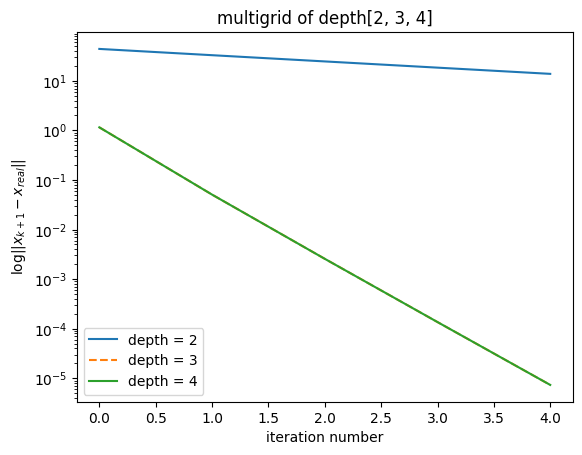

In [378]:
multigrid_test(size = 128, sigma = 5, multigrid_deep = [2,3,4], iter_number = 5,loud = 0)

## Тест на сходимость multigrid c _Cell_centred_ операторами Restriction и Prolongation

### Функция теста

In [379]:
def cell_centred_multigrid_test( size=128, sigma = 5, multigrid_deep = [2,3,4,5], iter_number = 10, pre_iter = 2, coarse_iter = 3, post_iter = 2,loud = 0):
  g=10
  H=1000
  L=10000
  dt=L/size*sigma/sqrt(g*H)

  matrix = full_operator(size,dt,L,g,H)
  real_answer = np.random.uniform(0, 10, size)
  right_part = matrix@real_answer
  logs=[]
  labels=[]
  title = " cell-centred vs vortex multigrid test".format(multigrid_deep)
  styles=[]

  for i in range(len(multigrid_deep)):
      print("calculating deep = {}".format(multigrid_deep[i]))
      logs.append(multigrid(np.zeros(size), matrix, right_part, real_answer, multigrid_deep[i], iter_number = iter_number, pre_iterations = pre_iter,coarse_iterations = coarse_iter, post_iterations = post_iter, loud = loud, Prolong_operator = Prolong_operator_cell_centred)[1])
      labels.append("cell-centred, depth = {}".format(multigrid_deep[i]))
      styles.append("--")

  for i in range(len(multigrid_deep)):
      print("calculating deep = {}".format(multigrid_deep[i]))
      logs.append(multigrid(np.zeros(size), matrix, right_part, real_answer, multigrid_deep[i], iter_number = iter_number, pre_iterations = pre_iter,coarse_iterations = coarse_iter, post_iterations = post_iter, loud = loud)[1])
      labels.append("vortex, depth = {}".format(multigrid_deep[i]))
      styles.append("-")
  logs_draw(logs,labels, styles, title)

### Сам тест

calculating deep = 3
calculating deep = 4
calculating deep = 3
calculating deep = 4


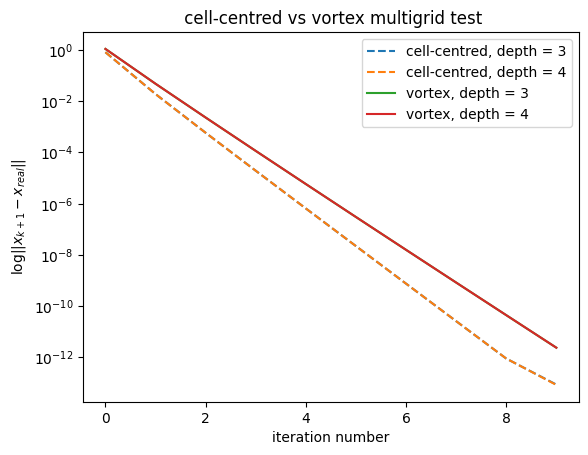

In [416]:
cell_centred_multigrid_test(size = 128, sigma = 5, multigrid_deep = [3,4], iter_number = 10, pre_iter = 2, coarse_iter = 3, post_iter = 2,loud = 0)

## Тест на multigrid с грубой матрицей

### Функции теста

In [381]:
def coarse_operator_multigrid_test(size=128, sigma = 5, multigrid_deep = [2,3], iter_number = 10, pre_iter = 2, coarse_iter = 3, post_iter = 2, loud = 0):
  g=10
  H=1000
  L=10000
  dt=L/size*sigma/sqrt(g*H)
  def matrix_func(Nx):
    return full_operator(Nx,dt,L,g,H)

  real_answer = np.random.uniform(0, 10, size)
  right_part = matrix_func(size)@real_answer
  logs=[]
  labels=[]
  styles=[]
  title = " cell-centred vs vortex multigrid on coarse matrix test".format(multigrid_deep)

  for i in range(len(multigrid_deep)):
      print("calculating deep = {}".format(multigrid_deep[i]))
      logs.append(multigrid_coarse_operator(np.zeros(size), matrix_func, right_part, real_answer, multigrid_deep[i], iter_number = iter_number, pre_iterations = pre_iter,coarse_iterations = coarse_iter, post_iterations = post_iter, loud = loud, Prolong_operator = Prolong_operator_cell_centred)[1])
      labels.append("cell_centred, depth = {}".format(multigrid_deep[i]))
      styles.append("--")
  for i in range(len(multigrid_deep)):
      print("calculating deep = {}".format(multigrid_deep[i]))
      logs.append(multigrid_coarse_operator(np.zeros(size), matrix_func, right_part, real_answer, multigrid_deep[i], iter_number = iter_number, pre_iterations = pre_iter,coarse_iterations = coarse_iter, post_iterations = post_iter, loud = loud)[1])
      labels.append("vortex, depth = {}".format(multigrid_deep[i]))
      styles.append("-")
  logs_draw(logs,labels, styles, title)

### Сам тест

calculating deep = 3
calculating deep = 4
calculating deep = 3
calculating deep = 4


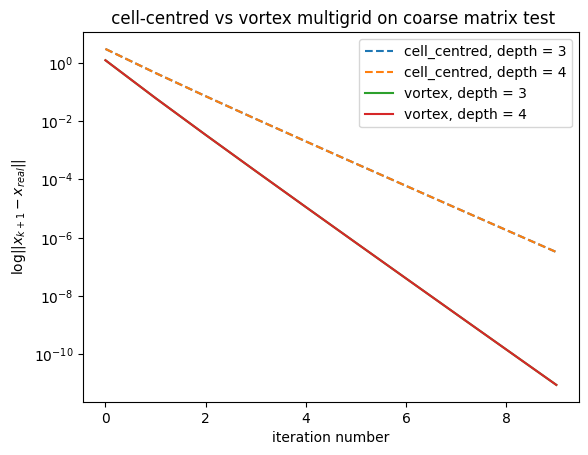

In [415]:
coarse_operator_multigrid_test(size=128, sigma = 5, multigrid_deep=[3,4], iter_number = 10, pre_iter = 2, coarse_iter = 3, post_iter = 2,loud = 0)

## Тест на сходимость метода двойной сетки

### Функция теста

In [383]:
def double_grid_test( size=32, iter_number = 10, pre_iter = [2,2,3,3], coarse_iter = [5,10,5,10], post_iter = [2,2,3,3]):
  g=10
  H=1000
  dt=1
  L=10000

  matrix = full_operator(size,dt,L,g,H)
  real_answer = np.random.uniform(0, 10, size)
  right_part = matrix@real_answer
  logs=[]
  labels=[]
  styles=["-","--","-","--","-","--"]
  title = "Double grid test on different inner iterations number"

  for i in range(len(coarse_iter)):
      logs.append(double_grid(np.zeros(size), matrix, right_part, real_answer, iter_number, pre_iter[i], coarse_iter[i], post_iter[i])[1])
      labels.append("pre = {}, coarse = {}, post = {}".format(pre_iter[i],coarse_iter[i],post_iter[i]))
      styles.append("--")
  logs_draw(logs,labels, styles, title)

### Сам тест

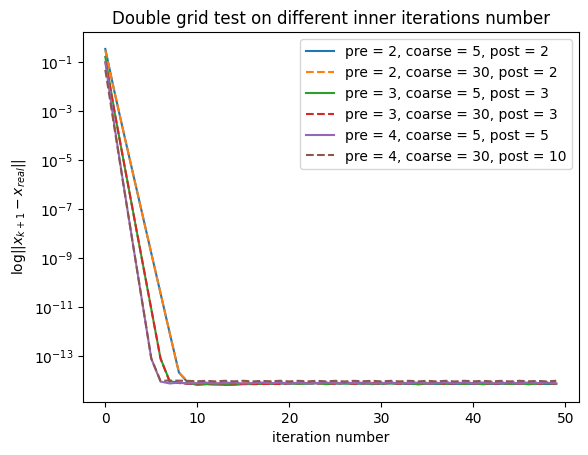

In [384]:
double_grid_test(size = 128, iter_number = 50, pre_iter = [2,2,3,3,4,4], coarse_iter = [5,30,5,30,5,30], post_iter = [2,2,3,3,5,10])

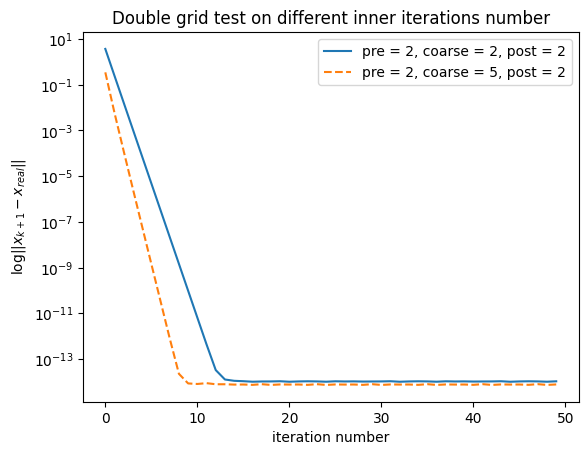

In [385]:
double_grid_test(size = 128, iter_number = 50, pre_iter = [2,2], coarse_iter = [2,5], post_iter = [2,2])

## Тест на сходимость разных методов при разных чилсах обусловленности

### Функция теста
- Вход это размер матрицы,шаг по времени, шаг по пространству, шаг по времени, шаг итерационного процесса, количество итераций, начальную точку, флаги для отрисовки, диапазоны отрисовки
- На выходе рисует (в директорию если поднят соответствующий флаг) картинки сходимости

In [386]:
def methods_test(method_step, start_point, right_part, size=100, dt=1, L=10000, iter_number = 100, write_flag = 0, log_flag = 0, start=0, end = 100):
  g = 10
  H = 1000
  dx=L/size
  matrix = full_operator(size,dt,L,g,H)
  real_answer = np.linalg.inv(matrix)@right_part
  mu = (1+4*g*H*dt*dt/dx/dx) # Число обусловленности
  print("mu ={}".format(mu))
  sg_log = sg_method(start_point, matrix, right_part, real_answer, iter_number)[1]
  sg_theor_log = sg_theoretical_method(start_point, matrix, right_part, real_answer, iter_number, mu)
  jacobi_log = jacobi_method(start_point, matrix,right_part,real_answer, iter_number)[1]
  jacobi_theor_log = jacobi_theor_method(start_point, matrix, right_part, real_answer, iter_number)
  labels=["conjudate","conjudate_theor","jacobi","jacobi_theor"]
  styles=["-","-.","-","-."]
  logs = [sg_log,sg_theor_log, jacobi_log, jacobi_theor_log]
  logs_draw(logs, labels,styles)

### Сам тест

In [387]:
size=100

mu =5.0
sg_theor q = 0.38196601125010515
jacob_theor q=0.6666666666666665


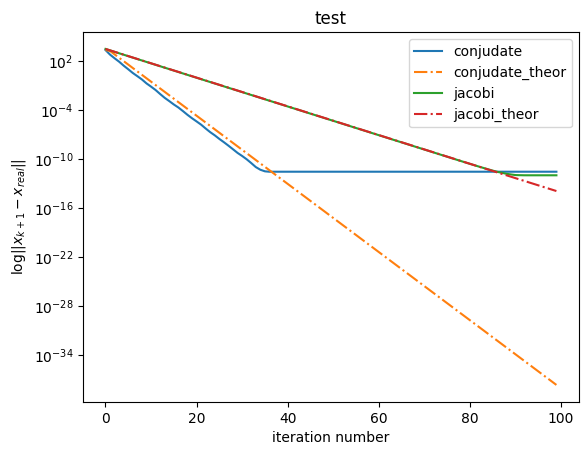

In [388]:
methods_test(method_step = 1, start_point = np.zeros(size), right_part = np.random.uniform(0.5, 1000, size))

mu =26.0
sg_theor q = 0.6720784389125772
jacob_theor q=0.925925925925926


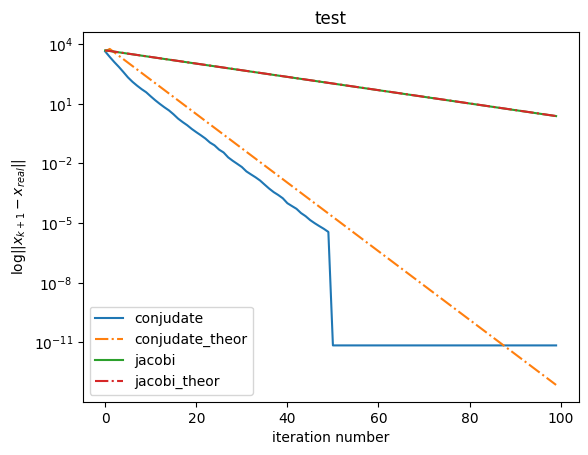

In [389]:
methods_test(method_step = 1, start_point = np.zeros(size), dt = 2.5, right_part = np.random.uniform(0.5, 1000, size), iter_number=100,write_flag = 0, log_flag = 1, end = 100, size = size)

mu =5.0
sg_theor q = 0.38196601125010515
jacob_theor q=0.6666666666666665


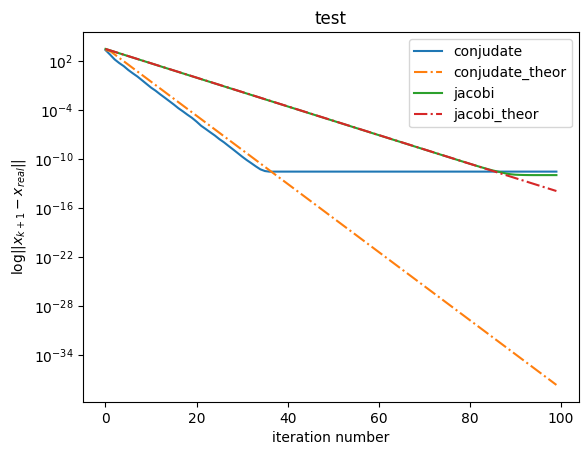

In [390]:
methods_test(method_step = 1, start_point = np.zeros(size), right_part = np.random.uniform(0.1, 1000, size), iter_number=100,write_flag = 0, log_flag = 1, end = 100, size = size)

mu =2.0
sg_theor q = 0.17157287525380996
jacob_theor q=0.33333333333333326


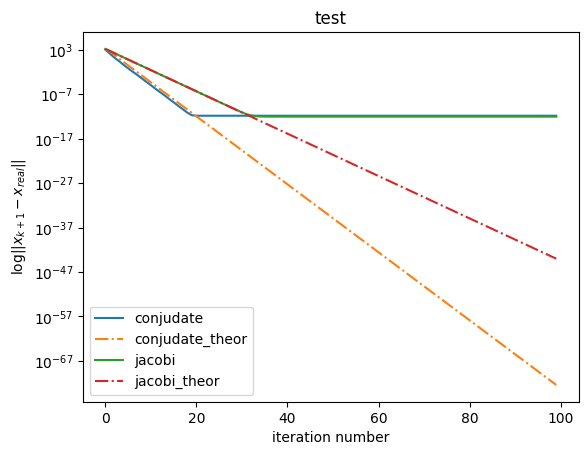

In [391]:
methods_test(method_step = 1, start_point = np.zeros(size), dt = 0.5, right_part = np.random.uniform(0.5, 1000, size), iter_number=100,write_flag = 0, log_flag = 1, end = 100, size = size)

mu =1.04
sg_theor q = 0.00980486407215173
jacob_theor q=0.01960784313725491


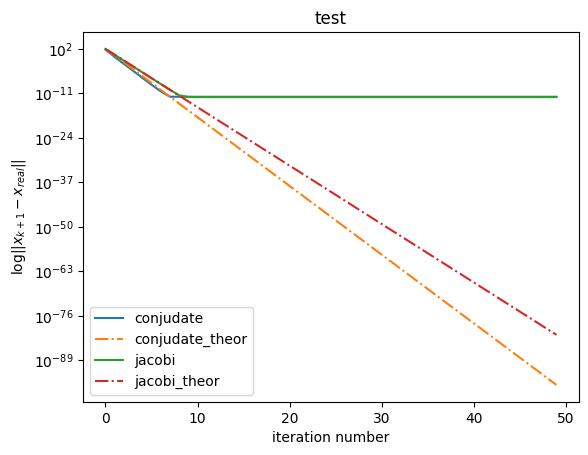

In [392]:
methods_test(method_step = 1, start_point = np.zeros(size),dt=0.1, right_part = np.random.uniform(0.1, 1000, size), iter_number=50,write_flag = 0, log_flag = 1, end = 50, size = size)

## Тест на гладкость ошибки во взвешенном методе Якоби

### Функция теста

In [393]:
def error_smooth(start_point = np.zeros(10), weights =[0.5,0.75, 1], size=10, dt=1, L=1, iter_number = 10, g = 10, H = 1000):
  assert len(start_point) == size
  dx=1/size
  matrix = full_operator(size, dt, L, g, H)
  xerlog=[]
  for i in range(len(weights)):
    real_answer = np.random.uniform(0, 10, size)
    right_part = matrix@real_answer
    xerlog.append(weighted_jacobi_method(start_point, matrix, right_part, real_answer, iter_number, weights[i])[2])
    plt.plot(range(size), xerlog[i], label = "w = {}".format(weights[i]))
    plt.ylabel(r"$x_i^{calc}-x_i^{real}$")
    plt.xlabel(r"$i$")
    plt.title("Weights jacob test")
    plt.legend()


### Сам тест

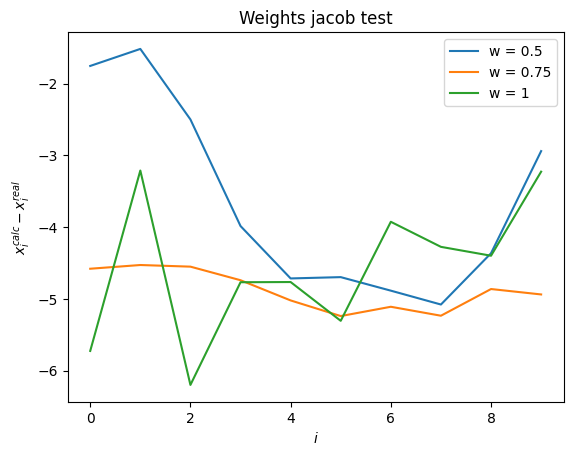

In [394]:
error_smooth(iter_number=3)

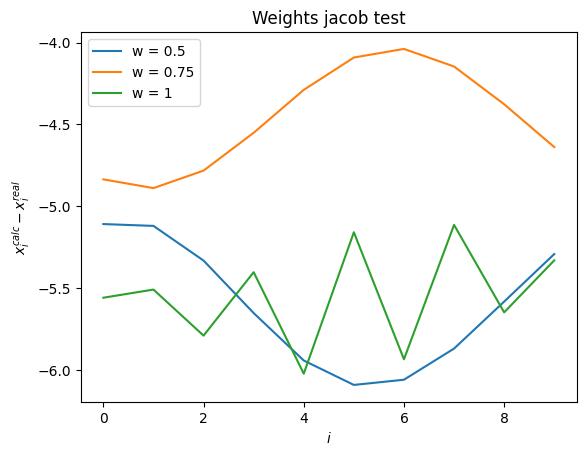

In [395]:
error_smooth(iter_number=10)

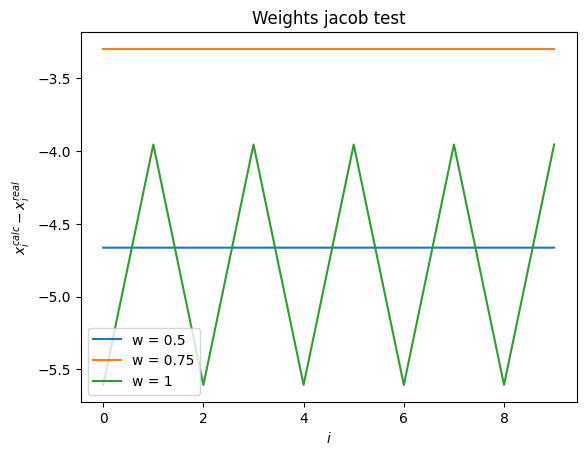

In [396]:
error_smooth(iter_number=100)

## Тесты операторов продолжения и сужения

### Функция теста

In [397]:
def compare_to_prolonged(func = np.sin, grid_size = 16, start = 0, L = 2*np.pi):
  short_points = np.linspace(start, start + L, grid_size)
  long_points  = np.linspace(start, start + L, 2*grid_size)
  return np.linalg.norm(func(long_points)-Prolong_operator(grid_size)@func(short_points),2)/grid_size

def compare_to_restricted(func = np.sin, grid_size= 16, start = 0, L = 2*np.pi):
#  assert grid_size%2==0
  short_points = np.linspace(start, start + L, int(grid_size/2))  #Очень плохо, надо дописать ассерт на делимость пополам
  long_points  = np.linspace(start, start + L, grid_size)
  return np.linalg.norm(func(short_points)-Restrict_operator(grid_size)@func(long_points),2)/grid_size

def compare_to_prolonged_restricted(func = np.sin, grid_size = 16, start = 0, L = 2*np.pi):
  points = np.linspace(start, start + L, grid_size)
  return np.linalg.norm(func(points)-Restrict_operator(2*grid_size)@(Prolong_operator(grid_size)@func(points)),2)/grid_size

def compare_to_restricted_prolonged(func = np.sin, grid_size = 16, start = 0, L = 2*np.pi):
  points = np.linspace(start, start + L, grid_size)
  return np.linalg.norm(func(points)-Prolong_operator(int(grid_size/2))@(Restrict_operator(grid_size)@func(points)),2)/grid_size #Очень плохо, надо дописать ассерт на делимость пополам

### Сам тест

In [398]:
Prolong_operator(8)

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5]])

In [399]:
Restrict_operator(8)

array([[0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25],
       [0.  , 0.25, 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.25, 0.5 , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.25]])

In [400]:
compare_to_prolonged(grid_size = 16)

0.03000129430715868

In [401]:
compare_to_prolonged(grid_size = 32)

0.01039547696114312

In [402]:
compare_to_restricted(grid_size = 16)

0.03288752906826088

In [403]:
compare_to_restricted(grid_size = 32)

0.010915767612908292

In [404]:
compare_to_prolonged_restricted(grid_size = 16)

0.005820711136033813

In [405]:
compare_to_prolonged_restricted(grid_size = 32)

0.0012778969158787124

In [406]:
compare_to_restricted_prolonged(grid_size = 16)

0.01925014223353844

In [407]:
compare_to_restricted_prolonged(grid_size = 32)

0.004004367810289007